# Statistics - Nav-Q vs NavA2C

In [1]:
from Utils import *

def print_stats(q_auc, c_auc, table=False):
    print(f"Mean:    | NavA2C vs Nav-Q | {c_auc.mean()} vs {q_auc.mean()}")
    print(f"Median:  | NavA2C vs Nav-Q | {np.percentile(c_auc, q=50, axis=0)}  vs {np.percentile(q_auc, q=50, axis=0)}")
    c_IQR = {np.percentile(c_auc, q=75, axis=0)} - {np.percentile(c_auc, q=25, axis=0)} 
    q_IQR = {np.percentile(q_auc, q=75, axis=0)} - {np.percentile(q_auc, q=25, axis=0)} 
    print(f"IQR:     | NavA2C vs Nav-Q | {c_IQR}  vs {q_IQR}")
    #print(f"Variance:| NavA2C vs Nav-Q | {c_auc.var()}  vs {q_auc.var()}")
    print(f"Std dev: | NavA2C vs Nav-Q | {c_auc.std()}  vs {q_auc.std()}")
    if table:
        quantum =   ['Nav-Q', q_auc.mean(), np.percentile(q_auc, q=50, axis=0), q_IQR, q_auc.std()]
        classical = ['NavA2C', c_auc.mean(), np.percentile(c_auc, q=50, axis=0), c_IQR, c_auc.std()]

        df = pd.DataFrame(columns=['Model', 'Mean', 'Median', 'Standard Deviation', 'IQR'])
        df.loc[0] = quantum
        df.loc[1] = classical
        return df
    else:
        return None

### Import Data

In [2]:
batch_path  = 'results\C_A2C_ls_32_multi_runs'
c_out = import_data_from_multiple_runs(batch_path)

q_batch_path  = 'results\Q_A2C_ls_32_q_4_l_2_multi_runs'
q_out = import_data_from_multiple_runs(q_batch_path)

### Plot Smoothed Averaged Curves

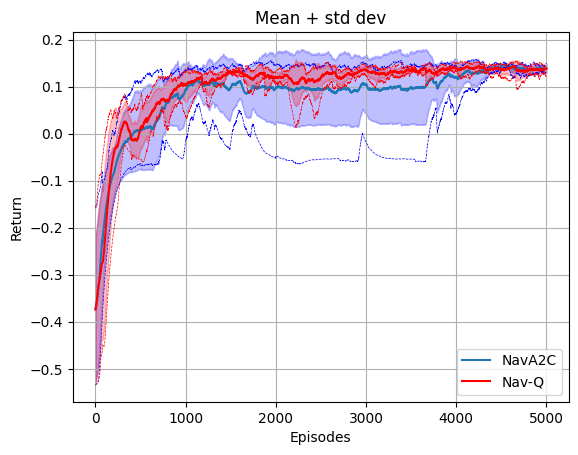

In [3]:
c_r, c_std_r, c_range_r, c_e, c_ci_e, c_range_e = get_inference(c_out)


plt.plot(c_r, label="NavA2C")
plt.fill_between(range(5000), (c_r-c_std_r), (c_r+c_std_r), color='blue', alpha=0.25)
plt.plot(c_range_r[0], linewidth = 0.5, color ="blue", linestyle='dashed')
plt.plot(c_range_r[1], linewidth = 0.5, color ="blue", linestyle='dashed')

q_r, q_std_r, q_range_r, q_e, q_ci_e, q_range_e = get_inference(q_out)
plt.plot(q_r, label="Nav-Q", color="red")
plt.fill_between(range(5000), (q_r-q_std_r), (q_r+q_std_r), color='red', alpha=0.25)
plt.plot(q_range_r[0], linewidth = 0.5, color ="red", linestyle='dashed')
plt.plot(q_range_r[1], linewidth = 0.5, color ="red", linestyle='dashed')

plt.grid()
plt.title("Mean + std dev")
plt.xlabel("Episodes")
plt.ylabel("Return")
plt.legend(loc="lower right")
plt.savefig('mean.png', dpi=200)

In [4]:
# Crate dataset
import pandas as pd

df1 = pd.DataFrame(data= (q_r, range(len(q_r)),np.repeat("quantum", len(q_r)))).transpose()
df2 = pd.DataFrame(data= (c_r, range(len(c_r)),np.repeat("classical", len(c_r)))).transpose()

df = pd.concat([df1,df2])

df.columns= ['R', 'Step', 'type']

df.to_csv('df_smoothed.csv',index=False,header=list(df.columns))

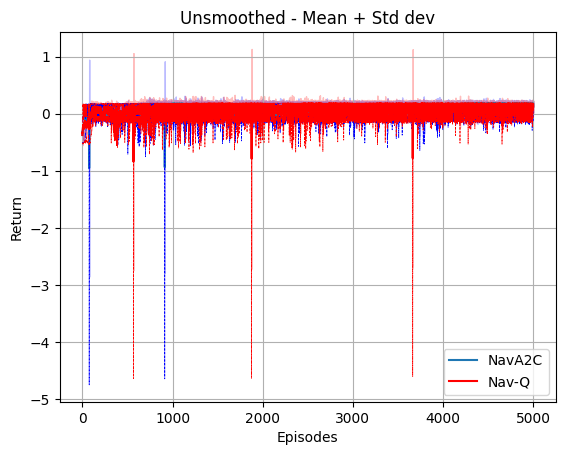

In [5]:
c_r, c_std_r, c_range_r, c_e, c_ci_e, c_range_e = get_inference(c_out, smoothed=False)


plt.plot(c_r, label="NavA2C")
plt.fill_between(range(5000), (c_r-c_std_r), (c_r+c_std_r), color='blue', alpha=0.25)
plt.plot(c_range_r[0], linewidth = 0.5, color ="blue", linestyle='dashed')
plt.plot(c_range_r[1], linewidth = 0.5, color ="blue", linestyle='dashed')

q_r, q_std_r, q_range_r, q_e, q_ci_e, q_range_e = get_inference(q_out, smoothed=False)
plt.plot(q_r, label="Nav-Q", color="red")
plt.fill_between(range(5000), (q_r-q_std_r), (q_r+q_std_r), color='red', alpha=0.25)
plt.plot(q_range_r[0], linewidth = 0.5, color ="red", linestyle='dashed')
plt.plot(q_range_r[1], linewidth = 0.5, color ="red", linestyle='dashed')

plt.grid()
plt.xlabel("Episodes")
plt.ylabel("Return")
plt.legend(loc="lower right")
plt.title('Unsmoothed - Mean + Std dev')
plt.savefig("unsmoothed_avg.png")


### AUC Sklearn

In [6]:
def auc_skl(q_out, c_out):
    from sklearn.metrics import auc

    q_auc = []
    c_auc = []
    
    x_sup = 5000
    
    for i in range(len(q_out['r'])):
        # print(len(q_out['r'][i][0:x_sup]))
        q_auc.append(auc(range(x_sup), q_out['r'][i][0:x_sup]))
        c_auc.append(auc(range(x_sup), c_out['r'][i][0:x_sup]))
        # c_auc.append(auc(range(len(c_out['r'][i])), c_out['r'][i]))
    
    q_auc = np.array(q_auc)
    c_auc = np.array(c_auc)

    
    q_auc_smooth = []
    c_auc_smooth = []
    
    for i in range(len(q_out['r'])):
        # print(len(q_out['r'][i][0:x_sup]))
        q_auc_smooth.append(auc(range(x_sup), smooth(q_out['r'][i][0:x_sup])[0]))
        c_auc_smooth.append(auc(range(x_sup),smooth(c_out['r'][i][0:x_sup])[0]))    
    
    q_auc_smooth = np.array(q_auc_smooth)
    c_auc_smooth = np.array(c_auc_smooth)
    
    return q_auc, c_auc, q_auc_smooth, c_auc_smooth

### AUC sklearn - results

In [7]:
print('Unsmoothed\n')
q_auc, c_auc, q_auc_smooth, c_auc_smooth = auc_skl(q_out, c_out)
df = print_stats(q_auc, c_auc, table=True)
print("\n", df.to_latex())

Unsmoothed

Mean:    | NavA2C vs Nav-Q | 461.1936079617706 vs 550.8334808957413
Median:  | NavA2C vs Nav-Q | 515.1664287275635  vs 558.1463125078008
IQR:     | NavA2C vs Nav-Q | {593.7028329143068}  vs {561.0957138417289}
Std dev: | NavA2C vs Nav-Q | 230.4207447436291  vs 20.027370155307352

 \begin{tabular}{llrrlr}
\toprule
 & Model & Mean & Median & Standard Deviation & IQR \\
\midrule
0 & Nav-Q & 550.833481 & 558.146313 & {561.0957138417289} & 20.027370 \\
1 & NavA2C & 461.193608 & 515.166429 & {593.7028329143068} & 230.420745 \\
\bottomrule
\end{tabular}



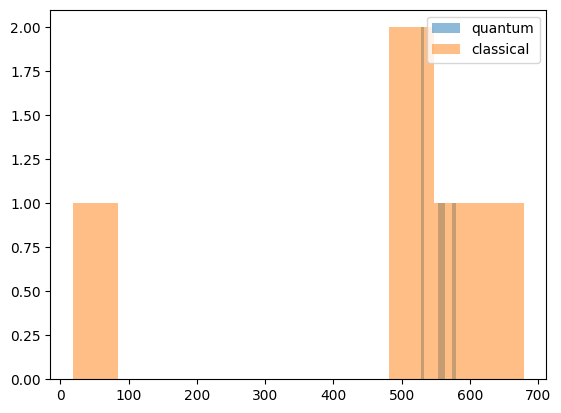

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.hist(q_auc, alpha=0.5, label='quantum')
plt.hist(c_auc, alpha=0.5, label='classical')
plt.legend(loc='upper right')
plt.show()

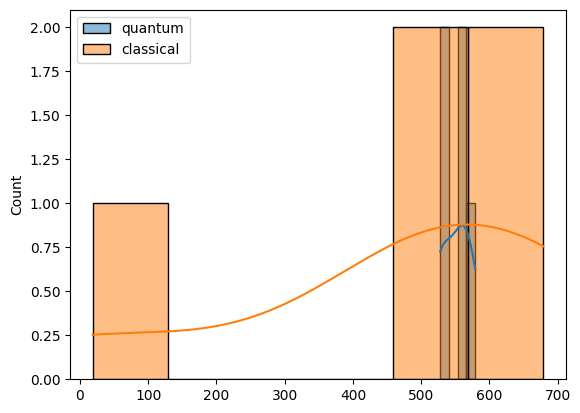

In [9]:
sns.histplot(q_auc, kde=True, label='quantum')
sns.histplot(c_auc, kde=True, label='classical')
plt.legend(loc='upper left')

In [10]:
print('Smoothed\n')
df = print_stats(q_auc_smooth, c_auc_smooth, table=True)
print("\n", df.to_latex())

Smoothed

Mean:    | NavA2C vs Nav-Q | 359.75119718807014 vs 448.9818915804634
Median:  | NavA2C vs Nav-Q | 384.90246740370554  vs 466.73923005582765
IQR:     | NavA2C vs Nav-Q | {536.4753530874091}  vs {484.03103797092814}
Std dev: | NavA2C vs Nav-Q | 220.04199570503488  vs 44.840611751334905

 \begin{tabular}{llrrlr}
\toprule
 & Model & Mean & Median & Standard Deviation & IQR \\
\midrule
0 & Nav-Q & 448.981892 & 466.739230 & {484.03103797092814} & 44.840612 \\
1 & NavA2C & 359.751197 & 384.902467 & {536.4753530874091} & 220.041996 \\
\bottomrule
\end{tabular}



In [11]:
q1=25
q2=50
q3=75

## Smoothed
c_r, c_std_r, c_range_r, c_e, c_ci_e, c_range_e = get_inference(c_out)
q_r, q_std_r, q_range_r, q_e, q_ci_e, q_range_e = get_inference(q_out)


dict_out = c_out

r = np.array([smooth(ele[:5000], weight=0.99)[0] for ele in dict_out["r"]])
e = np.array([smooth(ele[:5000], weight=0.99)[0] for ele in dict_out["e"]])
    
c_q25 = []
c_q50 = []
c_q75 = []

for i in range(len(r[0])):
    c_q25.append(np.percentile(r[:, i], q=q1, axis=0))
    c_q50.append(np.percentile(r[:, i], q=q2, axis=0))
    c_q75.append(np.percentile(r[:, i], q=q3, axis=0))

c_q25 = np.array(c_q25)
c_q50 = np.array(c_q50)
c_q75 = np.array(c_q75)


# ----------------------------------------------------------------------------- #
dict_out = q_out

r = np.array([smooth(ele[:5000], weight=0.99)[0] for ele in dict_out["r"]])
e = np.array([smooth(ele[:5000], weight=0.99)[0] for ele in dict_out["e"]])

q_q25 = []
q_q50 = []
q_q75 = []

for i in range(len(r[0])):
    q_q25.append(np.percentile(r[:, i], q=q1, axis=0))
    q_q50.append(np.percentile(r[:, i], q=q2, axis=0))
    q_q75.append(np.percentile(r[:, i], q=q3, axis=0))

q_q25 = np.array(q_q25)
q_q50 = np.array(q_q50)
q_q75 = np.array(q_q75)

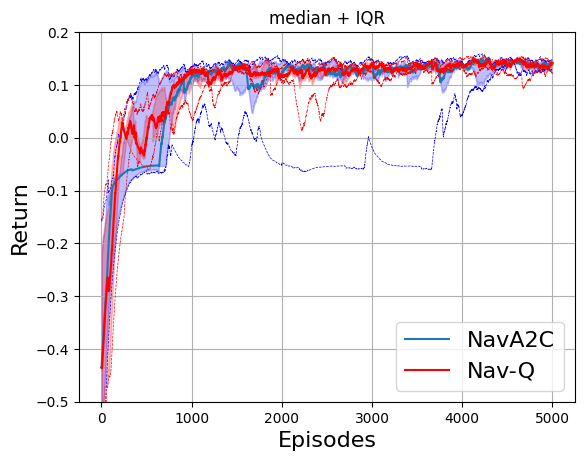

In [12]:
plt.plot(c_q50, label="NavA2C")
plt.fill_between(range(5000), c_q25, c_q75, color='blue', alpha=0.25)
plt.plot(c_range_r[0], linewidth = 0.5, color ="blue", linestyle='dashed')
plt.plot(c_range_r[1], linewidth = 0.5, color ="blue", linestyle='dashed')


plt.plot(q_q50, label="Nav-Q", color="red")
plt.fill_between(range(5000), q_q25, q_q75, color='red', alpha=0.25)
plt.plot(q_range_r[0], linewidth = 0.5, color ="red", linestyle='dashed')
plt.plot(q_range_r[1], linewidth = 0.5, color ="red", linestyle='dashed')
plt.ylim(-0.5, .2)


plt.grid()
plt.title("median + IQR")
plt.xlabel("Episodes", size=16)
plt.ylabel("Return", size=16)
plt.legend(loc="lower right", fontsize=16)
plt.savefig('IQR.png', dpi=200)